# Dataset Creation and Debugging

In [1]:
device = 'cuda' #cuda:0

In [41]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import numpy as np
from scipy.ndimage import morphology

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def init_semantic_segmentation_dataset(data_path, imgs_folder, masks_folder="Masks"):
    """ Prepare Semantic Segmentation dataset

    Arguments:
        data_path (string): path to dataset.
        imgs_folder (string): path to images (related of the data_path).
        masks_folder (string): path to masks (related of the data_path).

    Initialise dataset as a list of pairs {"image": <path_to_image>, "mask": <path_to_mask>}.
    """
    image_names = os.listdir(os.path.join(data_path, imgs_folder))
    dataset = []

    for img_name in image_names:
        
        #mask_name = os.path.join(data_path, masks_folder) + img_name.split('/')[-1] 
        
        mask_name = masks_folder + img_name.split('/')[-1] 

        if not os.path.isfile(mask_name): # Maybe the mask is not in .jpg format then we need to rename it as .png extension
            mask_name = img_name.replace('Inputs', 'Masks').replace(img_name.split('.')[-1], 'png')

        dataset.append({
            "image": os.path.join(data_path, imgs_folder, img_name),
            "mask": os.path.join(data_path, masks_folder, mask_name)
    })
        
    return dataset

def get_bg_seg_dataset(data_path, dataset_type='train', transforms=None):
    '''
    Get the combined dataset for Segmentation

    Arguments:
        data_path (string): path to dataset folder.
        dataset_type (string): dataset type (train, test or val).
        transforms (callable, optional): A function/transform that takes in a sample
            and returns a transformed version.

    Returns:
        dictionary with parameters of the dataset.
    '''

    return {
        "data_path": data_path,
            #os.path.join(data_path, "CamVid"),
        "images_folder":
            dataset_type + "/" + "Inputs/",
        "masks_folder":
            dataset_type + "/" + "Masks/",
        "num_classes":
            2,
        "transforms":
            transforms,
  
        "class_names": [
            'Person', 'Background'
        ]
    }

def draw_semantic_segmentation_samples(dataset, n_samples=3):
    """ Draw samples from semantic segmentation dataset.

    Arguments:
        dataset (iterator): dataset class.
        plt (matplotlib.pyplot): canvas to show samples.
        n_samples (int): number of samples to visualize.
    """
    fig, ax = plt.subplots(nrows=n_samples, ncols=2, sharey=True, figsize=(10, 10))
    for i, sample in enumerate(dataset):
        if i >= n_samples:
            break
        ax[i][0].imshow(sample["image"].numpy().transpose(1, 2, 0))
        ax[i][0].set_xlabel("image")
        ax[i][0].set_xticks([])
        ax[i][0].set_yticks([])
        
        ax[i][1].imshow(sample["mask"])
        ax[i][1].set_xlabel("mask")
        ax[i][1].set_xticks([])
        ax[i][1].set_yticks([])

    plt.tight_layout()
    plt.gcf().canvas.draw()
    plt.show()
    plt.close(fig)

In [42]:
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            num_classes (int): Number of classes in the dataset.
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            dataset_folder (string, optional): Folder containing the dataset (related to the git repo).

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder
            
            Names of images in the images_folder and masks_folder should match the same sample.

    """
    def __init__(
        self,
        data_path,
        images_folder,
        masks_folder,
        num_classes=2,
        transforms=None,
        class_names=None,
    ):

        self.num_classes = num_classes
        self.transforms = transforms
        self.class_names = class_names

        self.dataset = init_semantic_segmentation_dataset(data_path, images_folder, masks_folder)

    def get_num_classes(self):
        """Get number of classes in the dataset"""
        return self.num_classes


        
        return trimap
    
    def get_class_name(self, idx):
        """
            Get a specific class name

            Arguments:
                idx (int): index of specific class.

            Returns:
                If class_names are available and idx < number of classes,
                returns a specific class name, else returns an empty string.
        """
        class_name = ""
        if self.class_names is not None and idx < len(self.num_classes):
            class_name = self.class_names[idx]
        return class_name

    # get dataset's length
    def __len__(self):
        return len(self.dataset)

    # get item by index
    def __getitem__(self, idx):
                
        image = cv2.imread(self.dataset[idx]["image"])[..., ::-1]
        
        image = image.astype(np.float32)
        image = image / 255.0
        

        mean = [0.4506, 0.4045, 0.3643]
        std = [0.2579, 0.2404, 0.2261]
        
        image -= mean
        image /= std
        
        image = np.clip(image, 0, 1)
        
        mask = cv2.imread(self.dataset[idx]["mask"], 0) # 0 - cv2.IMREAD_GRAYSCALE
        
        #print("Before ", mask.shape)
        
        #mask = np.expand_dims(mask, axis=0)
        #mask = mask.transpose(1, 2, 0)
        
        #print("After ", mask.shape)
        
        mask = mask / 255.0
        
        #print("----", mask.min(), mask.max())
        
        mask = np.clip(mask, 0, 1)
        
        sample = {
            "image": image,
            "mask": mask
        }    
        
        # apply transforms to a sample
        if self.transforms is not None:
            
            sample = self.transforms(**sample)
            sample["mask"] = sample["mask"].long()
         
        return sample

In [39]:
root = "AllCombined/"

import albumentations as A
from albumentations import Compose, Normalize, RandomCrop, HorizontalFlip, ShiftScaleRotate, HueSaturationValue
from albumentations.pytorch import ToTensorV2

train_transforms= Compose([
                        HorizontalFlip(),
                        ShiftScaleRotate(
                            shift_limit=0.0625,
                            scale_limit=0.45,
                            rotate_limit=45,
                            value=0,
                            mask_value=0,
                            p=0.75
                        ),
                        #HueSaturationValue(),      # DONT use HueSaturationValue() as it wont be applied to Trimap and the Mask and it will mess up your data
                        A.Resize(240, 240),
                        RandomCrop(height=224, width=224),
                        #Normalize(),
                        ToTensorV2()
                    ])

test_transforms=Compose([A.Resize(224, 224), ToTensorV2()])


train_dataset = SemSegDataset(**get_bg_seg_dataset(
        data_path=root, dataset_type='train', transforms = train_transforms ))


In [29]:
len(train_dataset[0])

2

### Don't run the below cell, it takes 25 mins to run and calculate mean and std, for Combined47K dataset, means and std are as below

Calculated means: tensor([0.4506, 0.4045, 0.3643])

Calculated stds: tensor([0.2579, 0.2404, 0.2261])

In [20]:
# %%time

# means = torch.zeros(3)
# stds = torch.zeros(3)

# for img, trimap, mask in train_dataset:
#     means += torch.mean(img, dim = (1,2))
#     stds += torch.std(img, dim = (1,2))

# means /= len(train_dataset)
# stds /= len(train_dataset)
    
# print(f'Calculated means: {means}')
# print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4506, 0.4045, 0.3643])
Calculated stds: tensor([0.2579, 0.2404, 0.2261])
CPU times: user 23min 24s, sys: 10min 31s, total: 33min 55s
Wall time: 17min 10s


In [24]:
len(train_dataset)

6490

In [44]:
from tqdm.auto import tqdm

train_dataloader = DataLoader(train_dataset, batch_size=1, num_workers=2, pin_memory=True) 

iterator = tqdm(train_dataloader, disable=False, dynamic_ncols=True)

from operator import itemgetter

data_getter=itemgetter("image")
target_getter=itemgetter("mask")

for i, sample in enumerate(iterator):
    
    inputs = data_getter(sample).to(device)
    targets = target_getter(sample).to(device)
    
    print(inputs.min(), inputs.max(), targets.min(), targets.max())
    print(inputs.shape, targets.shape)
    
    break

  0%|          | 0/6490 [00:00<?, ?it/s]

tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(0, device='cuda:0') tensor(1, device='cuda:0')
torch.Size([1, 3, 224, 224]) torch.Size([1, 224, 224])


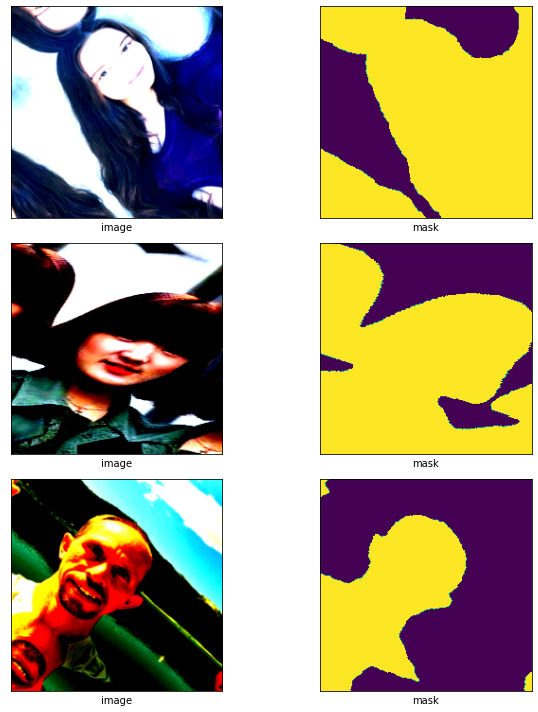

In [43]:
draw_semantic_segmentation_samples(train_dataset, n_samples=3)

# Metrics

In [45]:
from torchmetrics import IoU
import torch.nn as nn

import wandb
wandb.login()

class IoUMetric(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        
        self.iou = IoU(num_classes=num_classes)
        
    def forward(self, pred, target):
        
        iou = self.iou(pred, target)
        
        #wandb.log({"mean_iou": iou.mean()})
        
        return iou.mean()

wandb: Currently logged in as: rushirajsinh_parmar (use `wandb login --relogin` to force relogin)


# Training

In [46]:
from models.custom_modnet import CustomMODNet

model = CustomMODNet(backbone_pretrained=True).to(device)

bs = 14        # batch size
lr = 0.001       # learning rate
epochs = 10     # total epochs

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=4e-5)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)



In [47]:
from torch.utils.data import DataLoader

root = "AllCombined/"

train_dataset = SemSegDataset(**get_bg_seg_dataset(
        data_path=root, dataset_type='train', transforms = train_transforms ))

test_dataset = SemSegDataset(**get_bg_seg_dataset(
        data_path=root, dataset_type='test', transforms = test_transforms ))

import torch

train_dataloader = DataLoader(train_dataset, batch_size=bs, num_workers=4, pin_memory=True) 
test_dataloader = DataLoader(test_dataset, batch_size=8, num_workers=4, pin_memory=True) 

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=epochs)

print(len(train_dataloader))

464


In [48]:
config = dict(
        epochs=epochs,
        batch_size=bs,
        scheduler='OneCycleLR',
        learning_rate=lr,
        dataset="Combined47K",
        model = "Custom_MODNet-4L",
        train_type = 'MODNet-Style-Training-with-Aug'
    )
    

wandb.init(project = "SegExperiments", config=config, reinit=True) # mode="disabled" for disabling logging

#wandb sync
config = wandb.config

# Loss Functions

In [49]:
#PyTorch
import torch.nn.functional as F

class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [50]:
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [51]:
# combine the above two losses
import wandb

class CustomSemanticSegmentationLoss(nn.Module):
    """
        Implementation of the multi-objective loss function for semantic segmentation.

        Arguments:
            num_classes (int): number of classes.
            jaccard_alpha (float): weight of the SoftJaccardLoss
    """
    def __init__(self, num_classes, jaccard_alpha = 0.9, ignore_indices=-1):
        super().__init__()
        # init fields
        self.jaccard_alpha = jaccard_alpha
        self.jaccard = IoULoss()
        self.focal = FocalLoss()

    def forward(self, phase, pred_logits, target):
        """
            Compute Focal Loss.

            Arguments:
                pred_logits (torch.FloatTensor): tensor of predicted logits. The shape of the tensor is 
                (B, num_classes, H, W). targets (torch.LongTensor): tensor of ground-truth labels. 
                The shape of the tensor is (B, H, W).
        """
        jaccard_loss = self.jaccard_alpha * self.jaccard(pred_logits, target)
        
        #print("----", pred_logits.dtype, target.dtype)
        
        focal_loss = self.focal(pred_logits, target.float())
        
        total_loss = jaccard_loss + focal_loss
        
        if phase == 'train':
            wandb.log({"train_jaccard_loss": jaccard_loss, "train_focal_loss": focal_loss, "train_combined_loss": total_loss})
        if phase == 'test':
            wandb.log({"test_jaccard_loss": jaccard_loss, "test_focal_loss": focal_loss, "test_combined_loss": total_loss})
            
        return jaccard_loss, focal_loss, total_loss

In [52]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, count=1):
        self.val = val
        self.sum += val * count
        self.count += count
        self.avg = self.sum / self.count


In [ ]:
from tqdm.auto import tqdm

output_dir = 'model_checkpoints'

iou_metric = IoUMetric()


if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    

epoch_iterator = tqdm(range(epochs), dynamic_ncols=True)
stage_progress = False


from operator import itemgetter

data_getter=itemgetter("image")
target_getter=itemgetter("mask")


loss_fn = CustomSemanticSegmentationLoss(num_classes=2)
iou_metric = IoUMetric()


for epoch in epoch_iterator:
    
    total_loss_avg = AverageMeter()
    jaccard_loss_avg = AverageMeter()
    focal_loss_avg = AverageMeter()
    
    iterator = tqdm(train_dataloader, disable=stage_progress, dynamic_ncols=True)
    
    print(f"{epoch}/{epochs} start training")
    
    for i, sample in enumerate(iterator):
        
        optimizer.zero_grad()
        
        inputs = data_getter(sample).to(device)
        targets = target_getter(sample).to(device)
        
        #print("-----HOOKS----", inputs.min(), inputs.max(), targets.min(), targets.max())
        
        #print("-----HOOKS----", inputs.min(), inputs.max(), targets.min(), targets.max())
        
        predicts = model(inputs)
        
        jaccard_loss, focal_loss, total_loss = loss_fn("train", predicts, targets)
        
    
        total_loss.backward()
        optimizer.step()
        
        jaccard_loss_avg.update(jaccard_loss.item())
        focal_loss_avg.update(focal_loss.item())
        total_loss_avg.update(total_loss.item())
        
        status = "{0}[Train][{1}] total_loss_avg: {2:.5}, jaccard_loss: {3:.5}, focal_loss: {3:.5}, LR: {5:.5}".format(
            epoch, i, total_loss_avg.avg, jaccard_loss_avg.avg, focal_loss_avg.avg, optimizer.param_groups[0]["lr"]
        )
        
        iterator.set_description(status)
                    
            
    lr_scheduler.step()
    
    if epoch % 1 == 0:
        
        iterator = tqdm(test_dataloader, disable=stage_progress, dynamic_ncols=True)
        
        total_test_loss_avg = AverageMeter()
        test_jaccard_loss_avg = AverageMeter()
        test_focal_loss_avg = AverageMeter()
        
        miou_avg = AverageMeter()
        
        for idx, sample in enumerate(iterator):
            
            inputs = data_getter(sample).to(device)
            targets = target_getter(sample).to(device)
            
            predicts = model(inputs)
        
            jaccard_loss, focal_loss, total_loss = loss_fn("test", predicts, targets.float())
            
            test_jaccard_loss_avg.update(jaccard_loss.item())
            test_focal_loss_avg.update(focal_loss.item())
            total_test_loss_avg.update(total_loss.item())
    
            ################# METRIC PERFORMANCE CALCULATION ON TEST SET ###################
        
            predictions = torch.sigmoid(predicts)
            
            miou = iou_metric(predictions.cpu(), targets.int().detach().cpu())
            
            miou_avg.update(miou.item())
            
        wandb.log({"miou":  miou_avg.avg})
            
            
        print("--EVALUATION; EPOCH - {}--".format(epoch))
                  
        print(f"miou: {miou_avg.avg:.2f} total_test_loss {total_test_loss_avg.avg:.2f} test_jaccard_loss {test_jaccard_loss_avg.avg:.2f} test_focal_loss {test_focal_loss_avg.avg:.2f}")
            
        torch.save(model.state_dict(), os.path.join(output_dir, str(model.__class__.__name__) + f"_Epoch_{epoch}_miou_{miou_avg.avg:.2f}"))

/home/rushirajsinh/anaconda3/lib/python3.8/site-packages/deprecate/deprecation.py:115: FutureWarning: The `IoU` was deprecated since v0.7 in favor of `torchmetrics.classification.jaccard.JaccardIndex`. It will be removed in v0.8.
  stream(template_mgs % msg_args)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

0/10 start training


/home/rushirajsinh/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1945: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  0%|          | 0/594 [00:00<?, ?it/s]

--EVALUATION; EPOCH - 0--
miou: 0.86 total_test_loss 0.15 test_jaccard_loss 0.14 test_focal_loss 0.01


  0%|          | 0/464 [00:00<?, ?it/s]

1/10 start training


  0%|          | 0/594 [00:00<?, ?it/s]

--EVALUATION; EPOCH - 1--
miou: 0.89 total_test_loss 0.10 test_jaccard_loss 0.09 test_focal_loss 0.01


  0%|          | 0/464 [00:00<?, ?it/s]

2/10 start training


  0%|          | 0/594 [00:00<?, ?it/s]

--EVALUATION; EPOCH - 2--
miou: 0.90 total_test_loss 0.09 test_jaccard_loss 0.08 test_focal_loss 0.01


  0%|          | 0/464 [00:00<?, ?it/s]

3/10 start training


  0%|          | 0/594 [00:00<?, ?it/s]

--EVALUATION; EPOCH - 3--
miou: 0.90 total_test_loss 0.09 test_jaccard_loss 0.08 test_focal_loss 0.01


  0%|          | 0/464 [00:00<?, ?it/s]

4/10 start training


  0%|          | 0/594 [00:00<?, ?it/s]

--EVALUATION; EPOCH - 4--
miou: 0.91 total_test_loss 0.08 test_jaccard_loss 0.07 test_focal_loss 0.01


  0%|          | 0/464 [00:00<?, ?it/s]

5/10 start training


  0%|          | 0/594 [00:00<?, ?it/s]

--EVALUATION; EPOCH - 5--
miou: 0.92 total_test_loss 0.07 test_jaccard_loss 0.07 test_focal_loss 0.01


  0%|          | 0/464 [00:00<?, ?it/s]

6/10 start training


  0%|          | 0/594 [00:00<?, ?it/s]

--EVALUATION; EPOCH - 6--
miou: 0.90 total_test_loss 0.09 test_jaccard_loss 0.08 test_focal_loss 0.01


  0%|          | 0/464 [00:00<?, ?it/s]

7/10 start training


## Inference

In [10]:
from PIL import Image
import torchvision.transforms as transforms

pil_img = Image.open('test.jpeg')
print(pil_img.size)  
 
pil_to_tensor = transforms.ToTensor()(pil_img).unsqueeze_(0)
pil_to_tensor = transforms.Resize((224, 224))(pil_to_tensor)
print(pil_to_tensor.shape) 

(275, 183)
torch.Size([1, 3, 224, 224])


In [16]:
_, _, out = model(pil_to_tensor.to(device))

In [17]:
out = out.mul(255).clamp(0.0, 1.0)

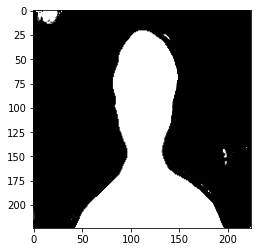

In [18]:
from torchvision.utils import make_grid

plt.imshow(np.transpose(make_grid(out[0].detach().cpu(), padding=2, normalize=False),(1,2,0)))

In [ ]:
def get_transform(train):
    if train:
        train_transform = A.Compose(
            [   
                A.MedianBlur(blur_limit=7, p=0.5),
                A.RandomGamma(gamma_limit=(90, 110), p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                A.InvertImg(p=0.3),
                A.HueSaturationValue(p=0.2),
                A.GaussNoise(p=0.5),
               A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),  
            ])
        return train_transform

      else:
        val_transform = A.Compose(
            [
             A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
              ToTensorV2(),
            ])
        return val_transform